# <center>TEXT DATA PREPROCESSING </center>

### IMPORT LIBRARIES

In [ ]:
import numpy as np
import pandas as pd 
import nltk 
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import OrderedDict, defaultdict
from collections import Counter
import re   
import matplotlib.pyplot as plt
import seaborn as sns

Install and inport necessary packages

In [2]:
for resource in ['punkt', 'punkt_tab', 'stopwords', 'wordnet', 'averaged_perceptron_tagger', 'averaged_perceptron_tagger_eng']:
    try:
        nltk.data.find(f'tokenizers/{resource}')
    except LookupError:
        nltk.download(resource)


from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


### LOAD DATA SET

In [3]:
data = pd.read_csv("../data/IMDB Dataset.csv")  # Load the dataset
reviews = data['review'].values  # Extract reviews from the dataset
labels = data['sentiment'].values  # Extract sentiment labels from the dataset
data.head() # Display the first few rows of the dataset

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### TOKENIZATION

Sentence Tokenization

In [4]:
sentences = []
for review in reviews:
    sentences.append(sent_tokenize(review))  # Sentence tokenization

sentences = [sent.lower() for review in sentences for sent in review]  # Flatten the list of sentences

In [ ]:
for i in range(len(sentences)):
    sentences[i] = re.sub(r'\W', ' ', sentences[i]) # Remove non-word characters
    sentences[i] = re.sub(r'[_]+', ' ', sentences[i])   # Remove underscores
    sentences[i] = re.sub(r'[\x00-\x1F\x7F]', ' ', sentences[i])    # Remove non-printable characters
    sentences[i] = re.sub(r'\d+', ' ', sentences[i])    # Remove digits
    sentences[i] = re.sub(r'br', ' ', sentences[i])  # Remove 'br' tags
    sentences[i] = re.sub(r'\s+', ' ', sentences[i])    # Replace multiple spaces with a single space
    sentences[i] = sentences[i].strip() # Trim leading and trailing spaces


In [6]:
print(len(sentences))  # Print the total number of sentences
print(sentences[:10]) # Print the first 10 sentences

537072
['one of the other reviewers has mentioned that after watching just oz episode you ll be hooked', 'they are right as this is exactly what happened with me the first thing that struck me about oz was its utality and unflinching scenes of violence which set in right from the word go', 'trust me this is not a show for the faint hearted or timid', 'this show pulls no punches with regards to drugs sex or violence', 'its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary', 'it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda', 'em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows would

Visualization

Average tokens per sentence: 21.81
Max tokens: 969
Min tokens: 0


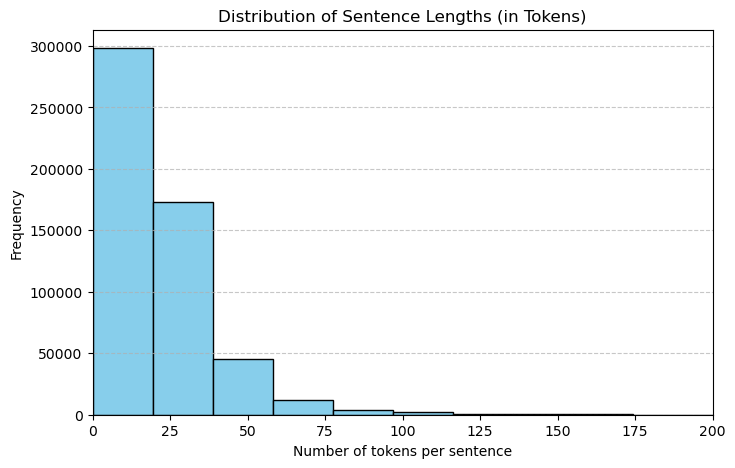

In [7]:
token_lengths = [len(sentence.split()) for sentence in sentences]

avg_len = sum(token_lengths) / len(token_lengths)
max_len = max(token_lengths)
min_len = min(token_lengths)

print(f"Average tokens per sentence: {avg_len:.2f}")
print(f"Max tokens: {max_len}")
print(f"Min tokens: {min_len}")

plt.figure(figsize=(8,5))
plt.hist(token_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Sentence Lengths (in Tokens)")
plt.xlabel("Number of tokens per sentence")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(0, 200)
plt.show()

Word Tokenization

In [8]:
words = []
for sentence in sentences:
    words.append(word_tokenize(sentence))  # Word tokenization

words = [word for review in words for word in review]  # Flatten the list of words

In [9]:
print(len(words))  # Print the total number of words
print(words[:100])  # Print the first review after word tokenization

11715026
['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', 'oz', 'episode', 'you', 'll', 'be', 'hooked', 'they', 'are', 'right', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'me', 'the', 'first', 'thing', 'that', 'struck', 'me', 'about', 'oz', 'was', 'its', 'utality', 'and', 'unflinching', 'scenes', 'of', 'violence', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'go', 'trust', 'me', 'this', 'is', 'not', 'a', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'timid', 'this', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs', 'sex', 'or', 'violence', 'its', 'is', 'hardcore', 'in', 'the', 'classic', 'use', 'of', 'the', 'word', 'it', 'is', 'called', 'oz', 'as', 'that', 'is', 'the', 'nickname', 'given', 'to', 'the', 'oswald']


Subword Tokenization using byte-pair encoding

Define function to be used

In [10]:
def create_char_vocabulary(review): # Function to create character-level vocabulary and their counts
    
    char_vocab = defaultdict(int)
    
    for token in review:
        # Convert each word to space-separated characters
        char_sequence = ' '.join(list(token))
        char_vocab[char_sequence] += 1
    
    return OrderedDict(sorted(char_vocab.items(), key=lambda x: x[1], reverse=True))

def get_pairs(vocab): # Function to get pairs of adjacent symbols in the vocabulary
    pairs = Counter()
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[(symbols[i], symbols[i+1])] += freq
    return pairs

def merge_vocab(vocab, pair):   # Function to merge the most frequent pair in the vocabulary
    new_vocab = {}
    old = ' '.join(pair)
    new = ''.join(pair)
    for word, freq in vocab.items():
        new_word = word.replace(old, new)
        new_vocab[new_word] = freq
    return new_vocab


Create character vocabulary from the word tokenized review

In [ ]:
char_vocab = defaultdict(int)
char_vocab = create_char_vocabulary(words)  # Create character-level vocabulary
    
ordered_char_vocab = OrderedDict(sorted(char_vocab.items(), key=lambda x: x[1], reverse=True)) # Sort the character vocabulary by frequency
print("Character-level vocabulary (top 10):")
for i, (char_seq, freq) in enumerate(ordered_char_vocab.items()):
    if i < 10: # Print only the top 10 most frequent character sequences
        print(f"'{char_seq}': {freq}")
    else:
        break

Character-level vocabulary (top 10):
't h e': 668010
'a n d': 324725
'a': 324057
'o f': 289416
't o': 268128
'i s': 211128
'i t': 190928
'i n': 186848
'i': 175656
't h i s': 151002


In [ ]:
# BPE Merging Process
num_merges = 500 # Number of BPE merges to perform
for _ in range(num_merges):
    pairs = get_pairs(char_vocab)
    if not pairs:   # if there is no more pair
        break
    most_common = pairs.most_common(1)[0][0]
    char_vocab = merge_vocab(char_vocab, most_common)
    print(f"Merged: {most_common} -> {''.join(most_common)}")

Merged: ('t', 'h') -> th
Merged: ('i', 'n') -> in
Merged: ('th', 'e') -> the
Merged: ('a', 'n') -> an
Merged: ('e', 'r') -> er
Merged: ('i', 's') -> is
Merged: ('r', 'e') -> re
Merged: ('o', 'n') -> on
Merged: ('a', 't') -> at
Merged: ('e', 'n') -> en
Merged: ('t', 'o') -> to
Merged: ('o', 'u') -> ou
Merged: ('in', 'g') -> ing
Merged: ('a', 'l') -> al
Merged: ('i', 't') -> it
Merged: ('e', 's') -> es
Merged: ('a', 's') -> as
Merged: ('an', 'd') -> and
Merged: ('o', 'r') -> or
Merged: ('o', 'f') -> of
Merged: ('a', 'r') -> ar
Merged: ('e', 'd') -> ed
Merged: ('i', 'l') -> il
Merged: ('s', 't') -> st
Merged: ('c', 'h') -> ch
Merged: ('l', 'y') -> ly
Merged: ('l', 'e') -> le
Merged: ('o', 'm') -> om
Merged: ('s', 'e') -> se
Merged: ('b', 'e') -> be
Merged: ('w', 'h') -> wh
Merged: ('a', 'c') -> ac
Merged: ('i', 'c') -> ic
Merged: ('o', 'v') -> ov
Merged: ('th', 'is') -> this
Merged: ('i', 'e') -> ie
Merged: ('n', 'o') -> no
Merged: ('a', 'd') -> ad
Merged: ('th', 'at') -> that
Merged: ('v

In [13]:
print("\nFinal Vocabulary:")
for word in char_vocab:
    print(word)


Final Vocabulary:
the
and
a
of
to
is
it
in
i
this
that
s
was
as
movie
for
with
but
film
you
t
on
not
he
are
his
have
one
be
all
at
they
by
an
who
so
from
like
there
or
just
her
out
about
if
has
what
can
some
good
when
more
very
she
up
no
time
my
even
would
which
only
story
really
see
their
had
me
well
we
were
other
than
much
bad
get
been
do
people
great
will
also
into
because
how
don
him
first
most
made
its
them
then
make
way
could
too
movies
any
after
characters
think
watch
character
films
two
many
seen
being
love
plot
never
life
acting
where
show
did
best
know
little
over
off
ever
man
does
your
better
end
here
scene
still
say
these
why
scenes
while
ve
something
m
such
go
should
through
back
real
those
now
thing
watching
actors
re
doesn
director
didn
years
funny
though
old
another
work
before
actually
nothing
makes
look
find
going
new
same
lot
every
few
again
part
world
down
cast
us
things
want
quite
pretty
horror
got
own
around
seems
young
take
big
however
thought
fact
enough
long
b

### REMOVING STOP WORD

In [14]:
stop_words = set(stopwords.words('english'))  # Define stopwords set

In [ ]:
filtered_sentences = []
for s in sentences:
    tokens = [w for w in s.lower().split() if w not in stop_words]  # Remove stopwords in sentences
    filtered_sentences.append(" ".join(tokens))

In [16]:
print(len(filtered_sentences))  # Print the total number of sentences after stopword removal
print(filtered_sentences[:10])  # Print the first 10 sentences after stopword removal

537072
['one reviewers mentioned watching oz episode hooked', 'right exactly happened first thing struck oz utality unflinching scenes violence set right word go', 'trust show faint hearted timid', 'show pulls punches regards drugs sex violence', 'hardcore classic use word called oz nickname given oswald maximum security state penitentary', 'focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda', 'em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare', 'forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around', 'first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence', 'violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned pri

Visualization


Average tokens before stopword removal: 21.81
Average tokens after stopword removal: 11.00


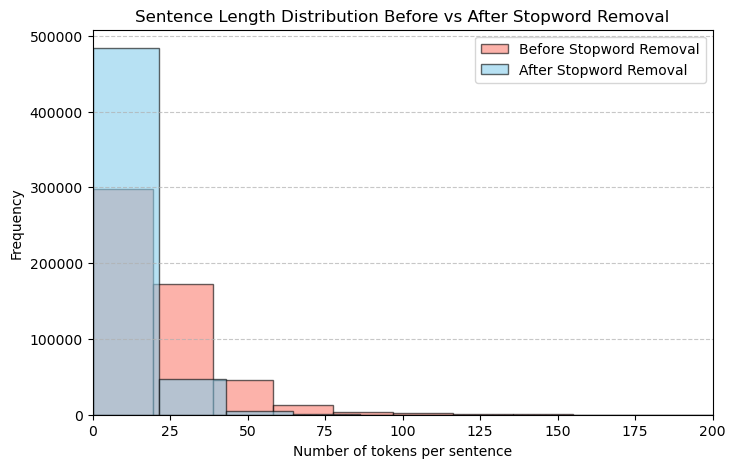

In [17]:
raw_lengths = [len(s.split()) for s in sentences]
filtered_lengths = [len(s.split()) for s in filtered_sentences]

avg_raw = sum(raw_lengths) / len(raw_lengths)
avg_filtered = sum(filtered_lengths) / len(filtered_lengths)

print(f"Average tokens before stopword removal: {avg_raw:.2f}")
print(f"Average tokens after stopword removal: {avg_filtered:.2f}")

# Vẽ histogram so sánh
plt.figure(figsize=(8,5))
plt.hist(raw_lengths, bins=50, alpha=0.6, label='Before Stopword Removal', color='salmon', edgecolor='black')
plt.hist(filtered_lengths, bins=20, alpha=0.6, label='After Stopword Removal', color='skyblue', edgecolor='black')
plt.title("Sentence Length Distribution Before vs After Stopword Removal")
plt.xlabel("Number of tokens per sentence")
plt.ylabel("Frequency")
plt.xlim(0, 200)  # Giới hạn trục X từ 0 đến 50
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:
filtered_words = []
filtered_words = [word for word in words if word not in stop_words]  # Remove stopwords from the list of words

In [19]:
print(len(filtered_words))  # Print the total number of words after stopword removal
print(filtered_words[:100])  # Print the first 100 words after stopword removal

5905045
['one', 'reviewers', 'mentioned', 'watching', 'oz', 'episode', 'hooked', 'right', 'exactly', 'happened', 'first', 'thing', 'struck', 'oz', 'utality', 'unflinching', 'scenes', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pulls', 'punches', 'regards', 'drugs', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'called', 'oz', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focuses', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cells', 'glass', 'fronts', 'face', 'inwards', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'many', 'aryans', 'muslims', 'gangstas', 'latinos', 'christians', 'italians', 'irish', 'scuffles', 'death', 'stares', 'dodgy', 'dealings', 'shady', 'agreements', 'never', 'far', 'away', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goes', 'shows', 'dare', 'forget', 'pretty', 'pictures', 'painted', 'mainstream', 'audiences', 'forget']


Visualization


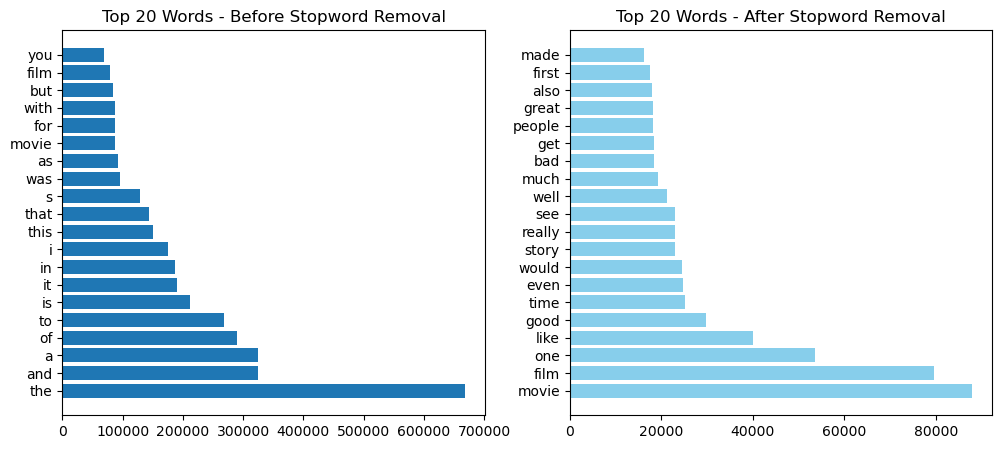

In [20]:
raw_counts = Counter(" ".join(words).split())
cleaned_counts = Counter(" ".join(filtered_words).split())

# Lấy top 20 từ
raw_common = dict(raw_counts.most_common(20))
cleaned_common = dict(cleaned_counts.most_common(20))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.barh(list(raw_common.keys()), list(raw_common.values()))
plt.title("Top 20 Words - Before Stopword Removal")

plt.subplot(1,2,2)
plt.barh(list(cleaned_common.keys()), list(cleaned_common.values()), color='skyblue')
plt.title("Top 20 Words - After Stopword Removal")
plt.show()

### STEMMING AND LEMMATIZATION

STEMMING

In [21]:
stemmer = PorterStemmer() # Initialize the Porter Stemmer
stemmed_words = []
for word in filtered_words:
    stemmed_words.append(stemmer.stem(word))  # Apply stemming to each word

In [22]:
print(stemmed_words[:100])  # Print the first 100 stemmed words

['one', 'review', 'mention', 'watch', 'oz', 'episod', 'hook', 'right', 'exactli', 'happen', 'first', 'thing', 'struck', 'oz', 'utal', 'unflinch', 'scene', 'violenc', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'heart', 'timid', 'show', 'pull', 'punch', 'regard', 'drug', 'sex', 'violenc', 'hardcor', 'classic', 'use', 'word', 'call', 'oz', 'nicknam', 'given', 'oswald', 'maximum', 'secur', 'state', 'penitentari', 'focus', 'mainli', 'emerald', 'citi', 'experiment', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inward', 'privaci', 'high', 'agenda', 'em', 'citi', 'home', 'mani', 'aryan', 'muslim', 'gangsta', 'latino', 'christian', 'italian', 'irish', 'scuffl', 'death', 'stare', 'dodgi', 'deal', 'shadi', 'agreement', 'never', 'far', 'away', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goe', 'show', 'dare', 'forget', 'pretti', 'pictur', 'paint', 'mainstream', 'audienc', 'forget']


 LEMMATIZATION

Define function to be used

In [ ]:
def get_wordnet_pos(word): # Function to map NLTK POS tags to WordNet POS tags
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV} # Mapping dictionary
    return tag_dict.get(tag, wordnet.NOUN) # Default to noun if not found

In [24]:
lemmatizer = WordNetLemmatizer()
lemmatized_words = []

for word in filtered_words:
    pos = get_wordnet_pos(word)  # Get the POS tag for the word
    lemmatized_words.append(lemmatizer.lemmatize(word, pos))  # Apply lemmatization

In [25]:
print(lemmatized_words[:100])  # Print the first 100 lemmatized words

['one', 'reviewer', 'mention', 'watch', 'oz', 'episode', 'hooked', 'right', 'exactly', 'happen', 'first', 'thing', 'struck', 'oz', 'utality', 'unflinching', 'scene', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pull', 'punch', 'regard', 'drug', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'call', 'oz', 'nickname', 'give', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focus', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inwards', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'many', 'aryan', 'muslim', 'gangsta', 'latino', 'christian', 'italian', 'irish', 'scuffle', 'death', 'stare', 'dodgy', 'dealing', 'shady', 'agreement', 'never', 'far', 'away', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'go', 'show', 'dare', 'forget', 'pretty', 'picture', 'paint', 'mainstream', 'audience', 'forget']


Visualization

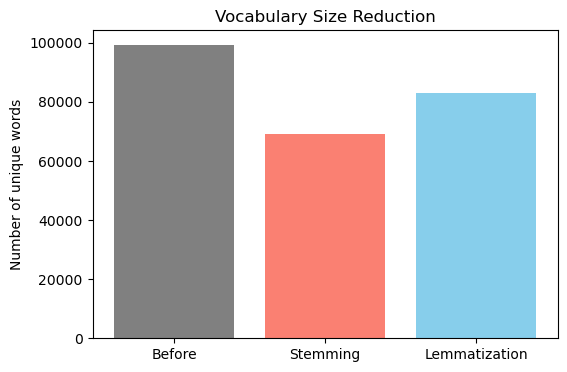

In [26]:
sizes = [len(set(filtered_words)), len(set(stemmed_words)), len(set(lemmatized_words))]
labels = ['Before', 'Stemming', 'Lemmatization']

plt.figure(figsize=(6,4))
plt.bar(labels, sizes, color=['gray', 'salmon', 'skyblue'])
plt.title("Vocabulary Size Reduction")
plt.ylabel("Number of unique words")
plt.show()

### TEXT VECTORIZATION

Create a sorted set of unique word to be used in one-hot encoding

In [27]:
vocabulary = sorted(set(lemmatized_words))  # Create a sorted set of unique words
print(len(vocabulary))
print(vocabulary[:300])

82955
['aa', 'aaa', 'aaaaaaaaaaaahhhhhhhhhhhhhh', 'aaaaaaaargh', 'aaaaaaah', 'aaaaaaahhhhhhggg', 'aaaaagh', 'aaaaah', 'aaaaahhhh', 'aaaaargh', 'aaaaarrrrrrgggggghhhhhh', 'aaaaatch', 'aaaaaw', 'aaaahhhhhh', 'aaaahhhhhhh', 'aaaand', 'aaaarrgh', 'aaaawwwwww', 'aaaggghhhhhhh', 'aaagh', 'aaah', 'aaahhhhhhh', 'aaall', 'aaam', 'aaand', 'aaargh', 'aaarrrgh', 'aaaugh', 'aaawwwwnnn', 'aab', 'aachen', 'aada', 'aadha', 'aag', 'aage', 'aagh', 'aaghh', 'aah', 'aahe', 'aahhh', 'aahhhh', 'aaila', 'aailiyah', 'aaip', 'aaja', 'aajala', 'aak', 'aakash', 'aake', 'aaker', 'aakrosh', 'aalcc', 'aaliyah', 'aalox', 'aames', 'aamir', 'aamr', 'aamto', 'aan', 'aankh', 'aankhen', 'aaoon', 'aap', 'aapke', 'aapkey', 'aaran', 'aardman', 'aardvark', 'aarf', 'aargh', 'aarika', 'aaron', 'aarp', 'aarrrgh', 'aashok', 'aasmaan', 'aasman', 'aatish', 'aaton', 'aau', 'aauugghh', 'aavjo', 'aawip', 'aaww', 'ab', 'aba', 'aback', 'abadi', 'abagail', 'abahy', 'abanazer', 'abandon', 'abandonment', 'abanks', 'abant', 'abase', 'abash

One-Hot Encoding

In [ ]:
  # Create a sorted set of unique words
encoder = OneHotEncoder(sparse_output=True)
encoded_reviews = encoder.fit_transform(np.array(vocabulary).reshape(-1, 1))  # One-hot encode the lemmatized words


In [29]:
for i, word in enumerate(vocabulary[:5]):
    print(f"{word} → {encoded_reviews[i].toarray()}")


aa → [[1. 0. 0. ... 0. 0. 0.]]
aaa → [[0. 1. 0. ... 0. 0. 0.]]
aaaaaaaaaaaahhhhhhhhhhhhhh → [[0. 0. 1. ... 0. 0. 0.]]
aaaaaaaargh → [[0. 0. 0. ... 0. 0. 0.]]
aaaaaaah → [[0. 0. 0. ... 0. 0. 0.]]


Visualization

Shape: (82955, 82955)
Vocabulary size: 82955


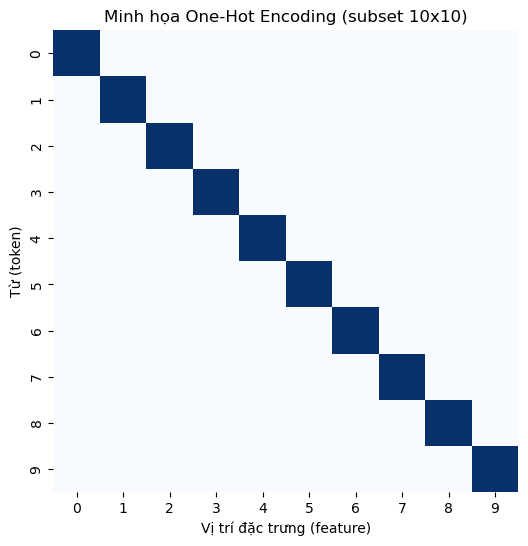

In [30]:
print("Shape:", encoded_reviews.shape)
print("Vocabulary size:", len(vocabulary))

subset = encoded_reviews[:10, :10].toarray()

plt.figure(figsize=(6, 6))
sns.heatmap(subset, cmap="Blues", cbar=False)
plt.title("Minh họa One-Hot Encoding (subset 10x10)")
plt.xlabel("Vị trí đặc trưng (feature)")
plt.ylabel("Từ (token)")
plt.show()

Bag of Word/ Count Vectorizer

In [31]:
vectorizer = CountVectorizer() # Initialize CountVectorizer
X = vectorizer.fit_transform(filtered_sentences)  # Fit and transform the filtered sentences

Visualization

In [32]:
sample = X[0].toarray()
sample_words = vectorizer.get_feature_names_out()

df = pd.DataFrame(sample, columns=sample_words)
print(df)

   aa  aaa  aaaaaaaaaaaahhhhhhhhhhhhhh  aaaaaaaargh  aaaaaaah  \
0   0    0                           0            0         0   

   aaaaaaahhhhhhggg  aaaaagh  aaaaah  aaaaahhhh  aaaaargh  ...  ünel  \
0                 0        0       0          0         0  ...     0   

   ünfaithful  üvegtigris  üzümcü  ýs  þorleifsson  þór  żmijewski  יגאל  \
0           0           0       0   0            0    0          0     0   

   כרמון  
0      0  

[1 rows x 99248 columns]


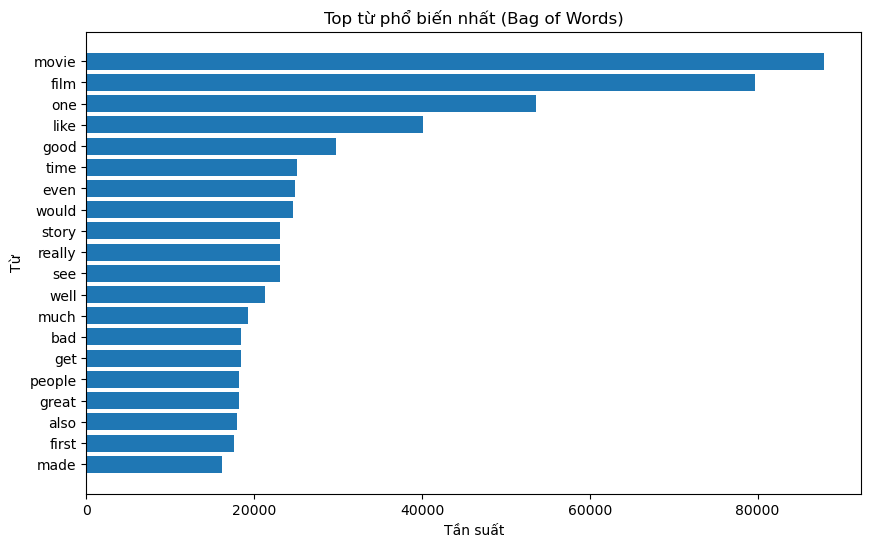

In [33]:
word_counts = np.asarray(X.sum(axis=0)).ravel()
top_n = 20
sorted_idx = np.argsort(word_counts)[::-1][:top_n]

plt.figure(figsize=(10, 6))
plt.barh(np.array(sample_words)[sorted_idx][::-1], word_counts[sorted_idx][::-1])
plt.xlabel("Tần suất")
plt.ylabel("Từ")
plt.title("Top từ phổ biến nhất (Bag of Words)")
plt.show()

Term Frequency-Inverse Document Frequency (TF-IDF)

In [34]:
tfidf_vectorizer = TfidfVectorizer() # Initialize TfidfVectorizer
X_tfidf = tfidf_vectorizer.fit_transform(filtered_sentences) # TF-IDF vectorize the common words

Visualization

In [35]:
sample = X_tfidf[0].toarray()
sample_words = tfidf_vectorizer.get_feature_names_out()

df = pd.DataFrame(sample, columns=sample_words)
print(df)

    aa  aaa  aaaaaaaaaaaahhhhhhhhhhhhhh  aaaaaaaargh  aaaaaaah  \
0  0.0  0.0                         0.0          0.0       0.0   

   aaaaaaahhhhhhggg  aaaaagh  aaaaah  aaaaahhhh  aaaaargh  ...  ünel  \
0               0.0      0.0     0.0        0.0       0.0  ...   0.0   

   ünfaithful  üvegtigris  üzümcü   ýs  þorleifsson  þór  żmijewski  יגאל  \
0         0.0         0.0     0.0  0.0          0.0  0.0        0.0   0.0   

   כרמון  
0    0.0  

[1 rows x 99248 columns]


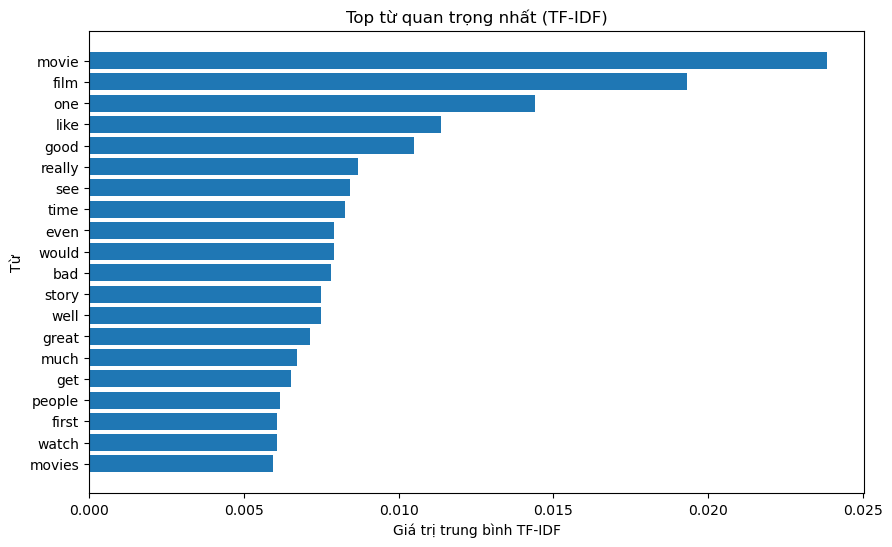

In [36]:
mean_tfidf = np.asarray(X_tfidf.mean(axis=0)).ravel()
sorted_idx = np.argsort(mean_tfidf)[::-1][:20]

plt.figure(figsize=(10, 6))
plt.barh(np.array(sample_words)[sorted_idx][::-1], mean_tfidf[sorted_idx][::-1])
plt.xlabel("Giá trị trung bình TF-IDF")
plt.ylabel("Từ")
plt.title("Top từ quan trọng nhất (TF-IDF)")
plt.show()